In [ ]:
#@title Default title text
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

In [1]:
import pandas as pd
import numpy as np

def to_month_id(year, month):
  return (year - 1996) * 12 + month - 6

n_features = 12
lookback = 3
chosen_stocks = ["EBAY"] # "AMZN", "MSFT", "IBM", "INTC", "QCOM", "NVDA", "IBM", "ADBE", "EBAY", "CSCO"

In [2]:
dfFeature = pd.read_csv("./lstm_2004_12.csv")
# dfFeature.loc[dfFeature["return"] == 0, "return"] = 1
dfFeature = dfFeature[dfFeature.QAId.isin(chosen_stocks)]
features = dfFeature.drop(columns=['month_id', 'QAId']).as_matrix()
print(features.shape)

(157, 12)


In [3]:
from sklearn.preprocessing import MinMaxScaler
normalizedFeatures = MinMaxScaler().fit_transform(features) \
                                   .reshape(157, len(chosen_stocks), n_features) \
                                   .reshape(157, len(chosen_stocks) * n_features)
print(normalizedFeatures.shape)

(157, 12)


In [4]:
dfTarget = pd.read_csv("./return_2004_40.csv")
dfTarget["return"] = np.sign(dfTarget["return"])
# dfTarget.loc[dfTarget["return"] == 0, "return"] = 1
dfTarget = dfTarget[dfTarget.QAId.isin(chosen_stocks)]
dfTarget = dfTarget[dfTarget.month_id >= (to_month_id(2004, 1) + lookback)]
targets = MinMaxScaler().fit_transform(dfTarget.drop(columns=['month_id', 'QAId']).as_matrix())
y = targets.reshape(157 - lookback + 1, len(chosen_stocks))
print(y.shape)

(155, 1)


In [5]:
from keras.preprocessing.sequence import TimeseriesGenerator

splittedFeature = normalizedFeatures
print(splittedFeature.shape)

/Users/billykwok/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(157, 12)


In [6]:
from keras.preprocessing.sequence import TimeseriesGenerator

x = np.zeros((157 - lookback + 1, lookback, n_features * len(chosen_stocks)))
y_mock = np.zeros((157, len(chosen_stocks)))

i = 0
for train, test in TimeseriesGenerator(splittedFeature, y_mock, length=lookback, batch_size=1):
  if i > 157 - lookback:
    break
  x[i] = train[0]
  i = i + 1

In [7]:
from sklearn.model_selection import PredefinedSplit

test_months = 26
end_point = 157 - lookback + 1
split_point = 157 - lookback + 1 - test_months

x_train = x[0:split_point - 48].reshape(split_point - 48, lookback, n_features * len(chosen_stocks))
y_train = y[0:split_point - 48].reshape(split_point - 48, len(chosen_stocks))
x_validate = x[split_point - 36:split_point].reshape(36, lookback, n_features * len(chosen_stocks))
y_validate = y[split_point - 36:split_point].reshape(36, len(chosen_stocks))
x_test = x[split_point:end_point].reshape(test_months, lookback, n_features * len(chosen_stocks))
y_test = y[split_point:end_point].reshape(test_months, len(chosen_stocks))

print(x_train.shape)
print(y_train.shape)
print(x_validate.shape)
print(y_validate.shape)
print(x_test.shape)
print(y_test.shape)

# ps = PredefinedSplit(np.append(np.negative(np.ones(60 * 465)), np.zeros(24 * 465))).split(x_train)

# for train_ids, test_ids in ps:
#   print(str(train_ids) + ", " + str(test_ids))

(81, 3, 12)
(81, 1)
(36, 3, 12)
(36, 1)
(26, 3, 12)
(26, 1)


In [70]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Flatten, CuDNNLSTM
from keras.regularizers import l1_l2, l2
from keras.optimizers import RMSprop, Adam
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

np.random.seed(4103)

def create_model(*param):
    model = Sequential()
    model.add(LSTM(units=512, input_shape=(lookback, n_features * len(chosen_stocks)), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=256, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(len(chosen_stocks), activation="relu"))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, decay=0.0), metrics=['accuracy'], *param)
    return model

In [71]:
batch_size=30

model = create_model()
train_score = model.fit(x_train, y_train, validation_data=(x_validate, y_validate), batch_size=batch_size, epochs=200)
print(train_score)

Train on 81 samples, validate on 36 samples
Epoch 1/200
81/81 [==============================] - 4s 54ms/step - loss: 1.6544 - acc: 0.5309 - val_loss: 1.4710 - val_acc: 0.5000
Epoch 2/200
81/81 [==============================] - 0s 2ms/step - loss: 1.2666 - acc: 0.5309 - val_loss: 1.2646 - val_acc: 0.5000
Epoch 3/200
81/81 [==============================] - 0s 2ms/step - loss: 1.0982 - acc: 0.5309 - val_loss: 1.1365 - val_acc: 0.5000
Epoch 4/200
81/81 [==============================] - 0s 2ms/step - loss: 1.0029 - acc: 0.5309 - val_loss: 1.0447 - val_acc: 0.5000
Epoch 5/200
81/81 [==============================] - 0s 2ms/step - loss: 0.9264 - acc: 0.5309 - val_loss: 0.9733 - val_acc: 0.5000
Epoch 6/200
81/81 [==============================] - 0s 2ms/step - loss: 0.8718 - acc: 0.5309 - val_loss: 0.9173 - val_acc: 0.5000
Epoch 7/200
81/81 [==============================] - 0s 2ms/step - loss: 0.8206 - acc: 0.5309 - val_loss: 0.8728 - val_acc: 0.5000
Epoch 8/200
81/81 [===================

Epoch 63/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6786 - acc: 0.6420 - val_loss: 0.6991 - val_acc: 0.5278
Epoch 64/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6776 - acc: 0.6173 - val_loss: 0.6988 - val_acc: 0.5000
Epoch 65/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6696 - acc: 0.6420 - val_loss: 0.6987 - val_acc: 0.5000
Epoch 66/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6781 - acc: 0.6296 - val_loss: 0.6987 - val_acc: 0.5278
Epoch 67/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6812 - acc: 0.6420 - val_loss: 0.6989 - val_acc: 0.5278
Epoch 68/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6784 - acc: 0.6296 - val_loss: 0.6992 - val_acc: 0.5278
Epoch 69/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6821 - acc: 0.6173 - val_loss: 0.6997 - val_acc: 0.5000
Epoch 70/200
81/81 [==============================] - 0s 2ms/step - loss: 0.

Epoch 125/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6643 - acc: 0.6296 - val_loss: 0.7099 - val_acc: 0.5000
Epoch 126/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6570 - acc: 0.6667 - val_loss: 0.7125 - val_acc: 0.5000
Epoch 127/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6608 - acc: 0.6914 - val_loss: 0.7141 - val_acc: 0.5278
Epoch 128/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6605 - acc: 0.6667 - val_loss: 0.7149 - val_acc: 0.5278
Epoch 129/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6664 - acc: 0.6296 - val_loss: 0.7146 - val_acc: 0.5278
Epoch 130/200
81/81 [==============================] - 0s 3ms/step - loss: 0.6658 - acc: 0.5926 - val_loss: 0.7141 - val_acc: 0.5000
Epoch 131/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6596 - acc: 0.6914 - val_loss: 0.7143 - val_acc: 0.5000
Epoch 132/200
81/81 [==============================] - 0s 2ms/step - 

81/81 [==============================] - 0s 2ms/step - loss: 0.6312 - acc: 0.7037 - val_loss: 0.7676 - val_acc: 0.5278
Epoch 187/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6440 - acc: 0.6914 - val_loss: 0.7711 - val_acc: 0.5278
Epoch 188/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6294 - acc: 0.7037 - val_loss: 0.7631 - val_acc: 0.5000
Epoch 189/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6408 - acc: 0.6543 - val_loss: 0.7633 - val_acc: 0.5000
Epoch 190/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6352 - acc: 0.6420 - val_loss: 0.7662 - val_acc: 0.5000
Epoch 191/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6373 - acc: 0.6914 - val_loss: 0.7690 - val_acc: 0.5000
Epoch 192/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6356 - acc: 0.6543 - val_loss: 0.7804 - val_acc: 0.5278
Epoch 193/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6349 -

26/26 [==============================] - 0s 626us/step
loss: 0.765826940536499
acc: 0.5


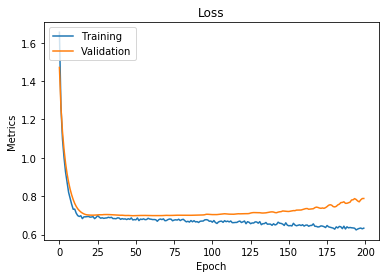

In [72]:
import matplotlib.pyplot as plt

test_score = model.evaluate(x_test, y_test, batch_size=batch_size)
for i, mn in enumerate(model.metrics_names):
  print(mn + ": " + str(test_score[i]))

plt.plot(train_score.history["loss"])
plt.plot(train_score.history["val_loss"])
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.legend(["Training", "Validation"], loc="upper left")
plt.show()

In [73]:
from sklearn.metrics import precision_score, recall_score, classification_report

def threshold_tester(result, target, a, b):
  for t in np.arange(a, b + 0.05, 0.05):
    print("thresholder: " + str(t))
    print(classification_report(target, (result >= t).astype(int)))

In [74]:
result = model.predict(x_test, batch_size=batch_size)
print(result)
threshold_tester(result, y_test, 0.1, 0.9)

[[0.41982383]
 [0.34690595]
 [0.32753676]
 [0.35161152]
 [0.49985594]
 [0.48365524]
 [0.55283034]
 [0.5339333 ]
 [0.4287281 ]
 [0.6361661 ]
 [0.52598524]
 [0.37305078]
 [0.4148199 ]
 [0.57844484]
 [0.5228593 ]
 [0.43795407]
 [0.4208304 ]
 [0.43743926]
 [0.5571462 ]
 [0.50994426]
 [0.36056125]
 [0.46968603]
 [0.54700446]
 [0.517686  ]
 [0.3991667 ]
 [0.8848782 ]]
thresholder: 0.1
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        10
        1.0       0.62      1.00      0.76        16

avg / total       0.38      0.62      0.47        26

thresholder: 0.15000000000000002
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        10
        1.0       0.62      1.00      0.76        16

avg / total       0.38      0.62      0.47        26

thresholder: 0.20000000000000004
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        10
        1.0    

/Users/billykwok/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [75]:
import math

buy_list = []
sell_list = []
def second_largest(numbers):
    count = 0
    m1 = m2 = float('-inf')
    for x in numbers:
        count += 1
        if x > m2:
            if x >= m1:
                m1, m2 = x, m1            
            else:
                m2 = x
    return m2 if count >= 2 else None

midpt = (second_largest(map(lambda x: x[0], result)) + min(map(lambda x: x[0], result))) / 2

for i, r in enumerate(result):
  buy_or_sell = 1 if r.item() > midpt * 1.05 else (-1 if r.item() < midpt * 0.95 else 0)
  if r.item() > midpt * 1.05:
    buy_list.append({'month_id': i + 223, 'QAId': chosen_stocks[0]})
  if r.item() < midpt * 0.95:
    sell_list.append({'month_id': i + 223, 'QAId': chosen_stocks[0]})
  print(str(y_test[i].item()) + ": " + str(buy_or_sell))
  if (math.fabs(buy_or_sell - y_test[i].item()) == 2) or (buy_or_sell - y_test[i].item() == 1):
    print("Hey")
print(buy_list)
print(sell_list)

1.0: -1
Hey
0.0: -1
1.0: -1
Hey
1.0: -1
Hey
0.0: 0
1.0: 0
0.0: 1
Hey
0.0: 1
Hey
1.0: -1
Hey
1.0: 1
0.0: 1
Hey
0.0: -1
1.0: -1
Hey
1.0: 1
1.0: 1
1.0: -1
Hey
0.0: -1
1.0: -1
Hey
1.0: 1
1.0: 1
0.0: -1
0.0: 0
1.0: 1
1.0: 1
1.0: -1
Hey
0.0: 1
Hey
[{'month_id': 229, 'QAId': 'EBAY'}, {'month_id': 230, 'QAId': 'EBAY'}, {'month_id': 232, 'QAId': 'EBAY'}, {'month_id': 233, 'QAId': 'EBAY'}, {'month_id': 236, 'QAId': 'EBAY'}, {'month_id': 237, 'QAId': 'EBAY'}, {'month_id': 241, 'QAId': 'EBAY'}, {'month_id': 242, 'QAId': 'EBAY'}, {'month_id': 245, 'QAId': 'EBAY'}, {'month_id': 246, 'QAId': 'EBAY'}, {'month_id': 248, 'QAId': 'EBAY'}]
[{'month_id': 223, 'QAId': 'EBAY'}, {'month_id': 224, 'QAId': 'EBAY'}, {'month_id': 225, 'QAId': 'EBAY'}, {'month_id': 226, 'QAId': 'EBAY'}, {'month_id': 231, 'QAId': 'EBAY'}, {'month_id': 234, 'QAId': 'EBAY'}, {'month_id': 235, 'QAId': 'EBAY'}, {'month_id': 238, 'QAId': 'EBAY'}, {'month_id': 239, 'QAId': 'EBAY'}, {'month_id': 240, 'QAId': 'EBAY'}, {'month_id': 243, 'QA

In [76]:
dfBuy = pd.DataFrame(buy_list, columns=["month_id", "QAId"])
dfSell = pd.DataFrame(sell_list, columns=["month_id", "QAId"])
dfBuy.head(5)
dfSell.head(5)

,month_id,QAId
0,223,EBAY
1,224,EBAY
2,225,EBAY
3,226,EBAY
4,231,EBAY


In [77]:
# from google.colab import files

filename_base = "_".join([stock.lower() for stock in chosen_stocks])
# filename_model = "./" + filename_base + "_model.h5"
# filename_weights = "./" + filename_base + "_weights.h5"
filename_output_buy = "./" + filename_base + "_output_buy.h5"
filename_output_sell = "./" + filename_base + "_output_sell.h5"

# model.save(filename_model)
# model.save_weights(filename_weights)
dfBuy.to_csv(filename_output_buy, index=False)
dfSell.to_csv(filename_output_sell, index=False)

# files.download(filename_model)
# files.download(filename_weights)
# files.download(filename_output_buy)
# files.download(filename_output_sell)